# Single-Shot Readout Calibration for UA Q2

### Using Experiment and Analysis Class, make sure to update qubit #

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qm.octave import QmOctaveConfig
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
#from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber
import xarray as xr

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 0 # for UA Q2
TLS_index = 0 # for TLS of interest
dc_flux_index = 1 # for dc line

2024-05-14 12:37:55,348 - qm - INFO     - Starting session: 2555f609-9764-4389-a00b-bab3cbee23d7


In [11]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle("quam_state_q1.json")
machine = Analysis.get_machine()

In [ ]:
# initialize Labber-controlled hardware
# get values from QDAC first
machine = Experiment.set_Labber.get_value_from_QDAC(machine)
# set all Labber settings
machine = Experiment.set_Labber.set_Labber(machine, qubit_index)
# set octave to external clock
Experiment.set_octave.set_clock(machine)

In [ ]:
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [ ]:
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

## 1D resonator spectroscopy

In [4]:
%matplotlib qt
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-5E6,5E6 + 1.0,0.05E6)
machine, expt_dataset = Experiment.exp1D.RR.rr_freq_ge(machine, res_freq_sweep, qubit_index, n_avg = 1E3, cd_time = 10E3,
                                                    to_simulate = False, simulation_len = 1000, live_plot = True)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 4.50s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 4.59s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0514\2024-05-14_q1_res_spec_ge_3


resonator frequency: 7133.571 MHz


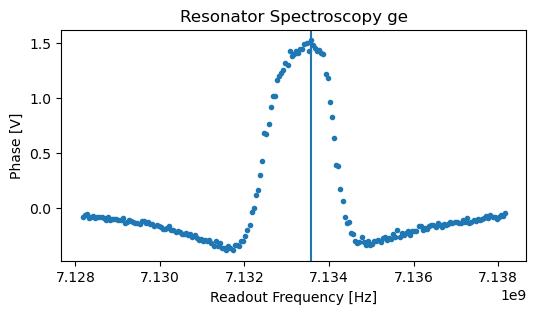

In [6]:
%matplotlib inline
res_freq_phase = Analysis.exp1D.rr_freq_ge(expt_dataset)

In [7]:
# doesn't have to update. Use res_freq_phase
machine.resonators[qubit_index].f_readout = res_freq_phase + 0E6
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

2024-05-14 12:38:43,237 - qm - INFO     - Performing health check
2024-05-14 12:38:43,253 - qm - INFO     - Health check passed
------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q1 for (LO, IF) = (6.250 GHz, -50.000 MHz)
2024-05-14 12:38:45,842 - qm - INFO     - Compiling program
------------------------------------- Calibrates r1 for (LO, IF) = (7.184 GHz, -50.000 MHz)
2024-05-14 12:38:53,936 - qm - INFO     - Compiling program
------------------------------------- Octave calibration finished.


## 1D qubit spectroscopy

In [ ]:
qubit_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-30E6, 30E6 + 1, 0.5E6)        
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.Rabi.qubit_freq(machine, qubit_freq_sweep, qubit_index, pi_amp_rel = 1.0, to_plot = False,
                                                         ff_amp = 0.0, n_avg = 1E3, cd_time = 30E3, simulate_flag = False, simulation_len = 1000)

In [ ]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(expt_dataset,method="Gaussian")
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.octaves[0].LO_sources[1].LO_frequency = machine.qubits[qubit_index].f_01 + 50e6
machine = Experiment.set_octave.calibration(machine, qubit_index)
machine = Analysis.set_machine(machine)

## Measure single-shot I, Q blobs

----------saved to Z:\QM_Data_DF5\2024\05\Data_0514\2024-05-14_q1_single_shot_IQ_6--> elapsed time: 1.87s


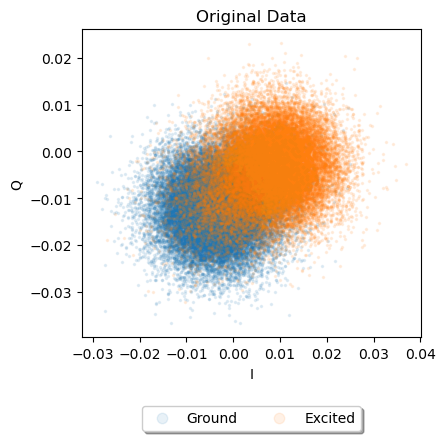

In [23]:
%matplotlib inline
machine, expt_dataset = Experiment.exp1D.RR.single_shot_IQ_blob(machine, qubit_index, n_avg = 30E3, cd_time = 30E3)


			Fidelity Matrix:
			-----------------
			| 0.884 | 0.116 |
			----------------
			| 0.192 | 0.808 |
			-----------------
			IQ plane rotated by: 324.1°
			Threshold: -2.504e-03
			Fidelity: 84.6%
			


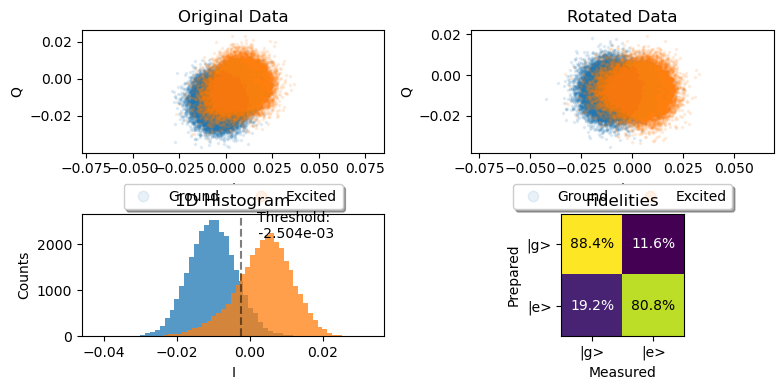

In [24]:
%matplotlib inline
angle, threshold, fidelity, gg, ge, eg, ee = Analysis.exp1D.two_state_discriminator(expt_dataset)

In [14]:
# set the rotation angle
machine.resonators[qubit_index].rotation_angle -= angle # note this is the change value not the absolute value!
machine.resonators[qubit_index].ge_threshold = threshold
machine = Analysis.set_machine(machine)

## optimize readout duration and amp

In [ ]:
%matplotlib qt
res_duration_sweep_abs = np.arange(300, 2000 + 1, 20)
res_amp_sweep = np.arange(0.05,0.5,0.002)
machine, res_amp_sweep, res_duration_sweep_abs, sig_amp = Experiment.exp2D.RR.rr_pulse_optimize(res_duration_sweep_abs, res_amp_sweep, qubit_index, res_index, flux_index, 
                    n_avg=10E3, cd_time=20E3, simulate_flag=False, simulation_len=1000, plot_flag=True, machine=machine)

In [ ]:
machine.resonators[res_index].readout_pulse_amp = 0.5
machine.resonators[res_index].readout_pulse_length = 1096
machine = Analysis.set_machine(machine)

## optimize single-shot frequency

In [15]:
res_freq_sweep = machine.resonators[qubit_index].f_readout + np.arange(-1.5E6, 1.5E6 + 1, 0.02E6)

%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_freq_optimization(machine, res_freq_sweep, qubit_index, n_avg = 2E3, cd_time = 25E3, 
                                                           final_plot = True, live_plot = True)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 15.51s
----------saved to Z:\QM_Data_DF5\2024\05\Data_0514\2024-05-14_q1_single_shot_freq_5
The optimal readout frequency is 7132990745.0 Hz (SNR=1.2201297328605551)
Execution stopped by user!


resonant frequency:  7133.1 [MHz]


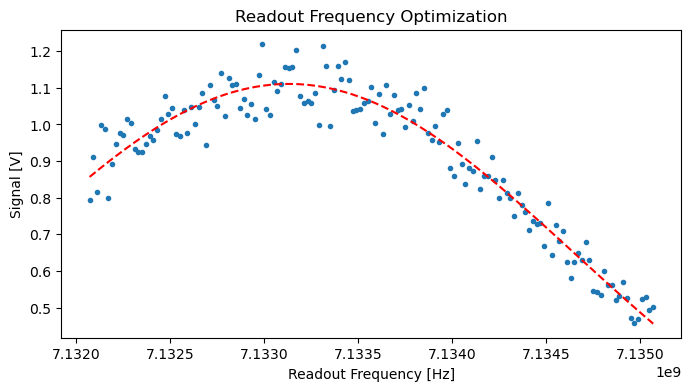

In [16]:
%matplotlib inline
res_freq = Analysis.exp1D.peak_fit(expt_dataset,method="Gaussian", SNR = True)

In [17]:
machine.resonators[qubit_index].f_readout = res_freq + 0E6
machine.octaves[0].LO_sources[0].LO_frequency = machine.resonators[qubit_index].f_readout + 50E6
machine = Analysis.set_machine(machine)
# octave calibration
machine = Experiment.set_octave.calibration(machine, qubit_index)

2024-05-14 12:40:50,123 - qm - INFO     - Performing health check
2024-05-14 12:40:50,134 - qm - INFO     - Health check passed
------------------------------------- Octave calibration starts...
------------------------------------- Calibrates q1 for (LO, IF) = (6.250 GHz, -50.000 MHz)
2024-05-14 12:40:52,699 - qm - INFO     - Compiling program
------------------------------------- Calibrates r1 for (LO, IF) = (7.183 GHz, -50.000 MHz)
2024-05-14 12:40:59,713 - qm - INFO     - Compiling program
------------------------------------- Octave calibration finished.


# These are from QM, and I don't think they work very well...

## optimize single-shot amplitude

In [18]:
res_amp_sweep = np.arange(0.5,1.5 + 1E-4, 0.01)

%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_amp_optimization(machine, res_amp_sweep, qubit_index,
                              n_avg = 5E3, cd_time = 25E3, final_plot= True)

some abs amps > 0.5, removed from experiment run
2024-05-14 12:41:26,466 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-05-14 12:41:26,497 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-05-14 12:41:26,526 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-05-14 12:41:26,556 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-05-14 12:41:26,583 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-05-14 12:41:26,614 - qm - ERROR    - Runtime errors were detected. Please fetch the execution report using job.execution_report() for more information
2024-05-14 12:4

peak voltage:  0.518 [V]


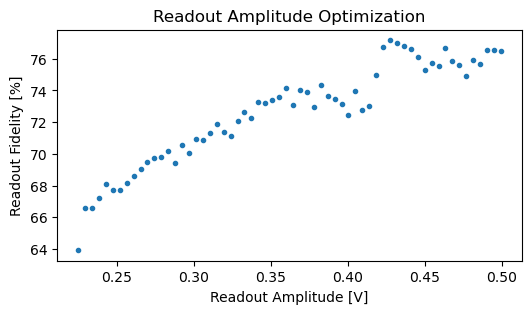

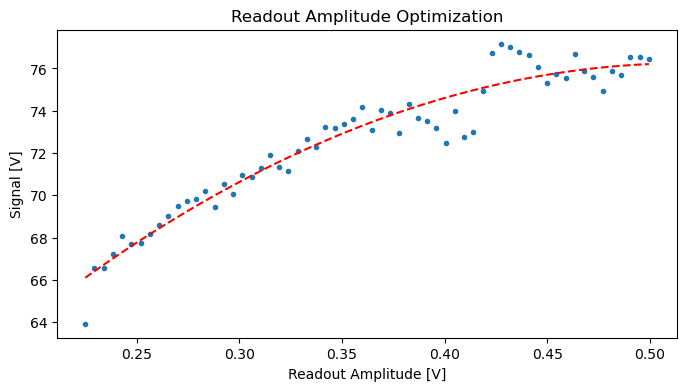

In [19]:
%matplotlib inline
readout_amp = Analysis.exp1D.peak_fit_fidelity(expt_dataset, method="Gaussian")

In [ ]:
machine.resonators[qubit_index].readout_pulse_amp = 0.45
machine = Analysis.set_machine(machine)

## optimize single-shot readout duration

In [20]:
division_length = 40
%matplotlib qt
machine, expt_dataset = Experiment.exp1D.RR.single_shot_duration_optimization(machine, division_length, qubit_index,
                                                                    readout_len = 2000, n_avg = 10E3, cd_time = 25E3)

Integration weights chunk-size length in ns: 40
The readout has been sliced in the following number of divisions 50
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 1.00s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 1.02s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 1.04s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 1.05s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 1.07s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 1.09s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 1.11s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed 

In [22]:
machine.resonators[qubit_index].readout_pulse_length = 800
machine = Analysis.set_machine(machine)